## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

Author: Zad Chin, Jay Yen Lim

All Rights Reserved. Copyright © Hyperbyte AI

In [1]:
!nvidia-smi

Sat Oct 12 07:10:06 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Install YOLOv8

⚠️ Download YOLOv8 with the command below. Do let your instructor know if you have any problem

In [2]:
# Install necessary libraries
!pip install ultralytics #==8.0.196
!pip install roboflow --quiet

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics 8.3.10 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 36.7/112.6 GB disk)


In [3]:
# Import Libraries
from ultralytics import YOLO
from IPython.display import display, Image
import os
import glob
import shutil
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.signal import savgol_filter
from roboflow import Roboflow

HOME = os.getcwd()
os.makedirs(f'{HOME}/datasets', exist_ok=True)

In [4]:
# Function to reset folders
def reset_runs_folder():
    runs_path = f"{HOME}/runs"
    if os.path.exists(runs_path):
        shutil.rmtree(runs_path)
        print(f"Deleted existing 'runs' folder: {runs_path}")

# Reset the 'runs' folder before starting
reset_runs_folder()

Deleted existing 'runs' folder: /content/runs


## Roboflow Universe

Follow your instructor on creating a custom project on Roboflow Universe!

**Do remember to login/sign up with Google first**


## Preparing a custom dataset

Building a custom dataset can be a painful process. It might take dozens or even hundreds of hours to collect images, label them, and export them in the proper format. Fortunately, Roboflow makes this process as straightforward and fast as possible. Let me show you how!

### Step 1: Creating project

Before you start, you need to create a Roboflow [account](https://app.roboflow.com/login). Once you do that, you can create a new project in the Roboflow [dashboard](https://app.roboflow.com/). Keep in mind to choose the right project type. In our case, Object Detection.


### Step 2: Uploading images

Next, add the data to your newly created project. You can do it via API or through our [web interface](https://docs.roboflow.com/adding-data/object-detection).

If you drag and drop a directory with a dataset in a supported format, the Roboflow dashboard will automatically read the images and annotations together.


### Step 3: Labeling

If you only have images, you can label them in [Roboflow Annotate](https://docs.roboflow.com/annotate).


### Step 4: Generate new dataset version

Now that we have our images and annotations added, we can Generate a Dataset Version. When Generating a Version, you may elect to add preprocessing and augmentations. This step is completely optional, however, it can allow you to significantly improve the robustness of your model.

**Remember to put something in validation step**

### Step 5: Exporting dataset

Once the dataset version is generated, we have a hosted dataset we can load directly into our notebook for easy training. Click `Export` and select the `YOLO v8 PyTorch` dataset format.


### Step 6: Getting API

Go back to the main page, under `Settings` and select `API keys`. Copy Private API Key (for almost all use cases, like inference and REST API)


In [5]:
# Go to the datasets folder
%cd {HOME}/datasets

# **Change** this API key
rf = Roboflow(api_key="GybthxK3Mzs6LO2oHyMZ")

# **Change** Copy the code from Roboflow, remember to put yolo v8
project = rf.workspace("project-ih87b").project("skin-cancer-detection-jfdll")
version = project.version(3)
dataset = version.download("yolov8")

/content/datasets
loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.3.10, to fix: `pip install ultralytics==8.0.196`


## Custom Training

In [12]:
# Reset Run Folder
reset_runs_folder()

# Define the model
model = YOLO("yolov8s.pt")

results_path = f"{HOME}/runs/detect/train"
if not os.path.exists(results_path):
    # Train the Model, hyperparameter is as explained in part 1
    model.train(data=f"{dataset.location}/data.yaml", conf=0.5, epochs=100, project=f"{HOME}/runs/detect", name="train", exist_ok=True)
else:
    print("Training folder already exists. Skipping training.")

Deleted existing 'runs' folder: /content/runs
Ultralytics 8.3.10 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/datasets/Skin-Cancer-detection-3/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/runs/detect, name=train, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=0.5, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt

train: Scanning /content/datasets/Skin-Cancer-detection-3/train/labels.cache... 60 images, 0 backgrounds, 0 corrupt: 100%|██████████| 60/60 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/datasets/Skin-Cancer-detection-3/valid/labels.cache... 20 images, 0 backgrounds, 0 corrupt: 100%|██████████| 20/20 [00:00<?, ?it/s]


Plotting labels to /content/runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 63 weight(decay=0.0), 70 weight(decay=0.0005), 69 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      4.07G      1.854      3.413      2.207         24        640: 100%|██████████| 4/4 [00:01<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]

                   all         20         20          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      3.91G      1.785      3.364      2.174         24        640: 100%|██████████| 4/4 [00:01<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.31it/s]

                   all         20         20          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      4.09G      1.553      3.277      2.072         31        640: 100%|██████████| 4/4 [00:01<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.32it/s]

                   all         20         20          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      3.99G      1.285      2.964      1.721         26        640: 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]

                   all         20         20          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      4.17G      1.268      2.729      1.632         28        640: 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]

                   all         20         20          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      4.19G      1.355      2.635      1.726         25        640: 100%|██████████| 4/4 [00:01<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.66it/s]

                   all         20         20          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      4.03G      1.403       2.43      1.727         31        640: 100%|██████████| 4/4 [00:01<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.29it/s]

                   all         20         20          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      4.19G      1.384      2.392      1.728         32        640: 100%|██████████| 4/4 [00:01<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.47it/s]

                   all         20         20          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      4.02G      1.323      2.272      1.706         23        640: 100%|██████████| 4/4 [00:01<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.95it/s]

                   all         20         20          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      4.02G      1.366      2.204       1.72         32        640: 100%|██████████| 4/4 [00:01<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.37it/s]

                   all         20         20          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100       4.2G      1.441      2.334      1.814         29        640: 100%|██████████| 4/4 [00:01<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]

                   all         20         20          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      4.18G      1.546      2.274      1.832         26        640: 100%|██████████| 4/4 [00:01<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.54it/s]

                   all         20         20          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      4.19G      1.429      2.181      1.735         26        640: 100%|██████████| 4/4 [00:01<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.43it/s]

                   all         20         20          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      4.19G      1.367       2.09      1.668         30        640: 100%|██████████| 4/4 [00:01<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.17it/s]


                   all         20         20          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      4.02G      1.358      2.169      1.697         20        640: 100%|██████████| 4/4 [00:01<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.69it/s]

                   all         20         20          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100         4G      1.347      1.972      1.724         29        640: 100%|██████████| 4/4 [00:01<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.72it/s]

                   all         20         20          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      4.18G       1.39      2.203      1.811         22        640: 100%|██████████| 4/4 [00:01<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.51it/s]

                   all         20         20          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      4.18G      1.348      1.943      1.672         35        640: 100%|██████████| 4/4 [00:01<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]

                   all         20         20          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100         4G      1.391      1.827      1.655         31        640: 100%|██████████| 4/4 [00:01<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.41it/s]


                   all         20         20          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      4.19G      1.376      1.832       1.72         27        640: 100%|██████████| 4/4 [00:01<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.99it/s]

                   all         20         20          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      4.18G      1.465      1.969      1.808         29        640: 100%|██████████| 4/4 [00:01<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.67it/s]

                   all         20         20          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100         4G      1.558      1.986      1.761         28        640: 100%|██████████| 4/4 [00:01<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.44it/s]

                   all         20         20          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      4.17G      1.541      2.032      1.769         29        640: 100%|██████████| 4/4 [00:01<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.98it/s]

                   all         20         20          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100         4G      1.621      2.107      1.939         22        640: 100%|██████████| 4/4 [00:01<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.74it/s]

                   all         20         20          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100         4G      1.375      1.927      1.781         26        640: 100%|██████████| 4/4 [00:01<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.53it/s]

                   all         20         20        0.5       0.05      0.275      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100         4G      1.473       1.91      1.791         28        640: 100%|██████████| 4/4 [00:01<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.03it/s]


                   all         20         20      0.201       0.05     0.0693     0.0277

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100         4G      1.445       1.94      1.731         29        640: 100%|██████████| 4/4 [00:01<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.72it/s]

                   all         20         20      0.201       0.05     0.0693     0.0277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100         4G      1.488      1.927      1.746         24        640: 100%|██████████| 4/4 [00:01<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.48it/s]

                   all         20         20      0.201       0.05     0.0693     0.0277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100         4G      1.426      1.893      1.757         25        640: 100%|██████████| 4/4 [00:01<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]

                   all         20         20      0.201       0.05     0.0693     0.0277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100         4G       1.32      1.868      1.692         28        640: 100%|██████████| 4/4 [00:01<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]

                   all         20         20      0.201       0.05     0.0693     0.0277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100         4G      1.363      1.776      1.663         31        640: 100%|██████████| 4/4 [00:01<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.77it/s]

                   all         20         20      0.201       0.05     0.0693     0.0277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100         4G      1.473      1.721      1.704         35        640: 100%|██████████| 4/4 [00:01<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.14it/s]


                   all         20         20      0.201       0.05     0.0693     0.0277

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100         4G      1.287      1.691      1.613         27        640: 100%|██████████| 4/4 [00:01<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.08it/s]

                   all         20         20      0.201       0.05     0.0693     0.0277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100         4G      1.354      1.644      1.628         31        640: 100%|██████████| 4/4 [00:01<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.57it/s]

                   all         20         20      0.201       0.05     0.0693     0.0277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100         4G       1.38      1.597      1.669         28        640: 100%|██████████| 4/4 [00:01<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.85it/s]

                   all         20         20      0.201       0.05     0.0693     0.0277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100         4G       1.34      1.586      1.614         25        640: 100%|██████████| 4/4 [00:01<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.06it/s]

                   all         20         20      0.201       0.05     0.0693     0.0277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100         4G      1.329      1.522      1.604         30        640: 100%|██████████| 4/4 [00:01<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]

                   all         20         20      0.201       0.05     0.0693     0.0277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100         4G      1.346      1.665      1.718         23        640: 100%|██████████| 4/4 [00:01<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.06it/s]


                   all         20         20      0.333        0.1        0.2     0.0999

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100         4G       1.38      1.628      1.712         23        640: 100%|██████████| 4/4 [00:01<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.43it/s]

                   all         20         20        0.3        0.3      0.286      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100         4G       1.28      1.568      1.648         31        640: 100%|██████████| 4/4 [00:01<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.36it/s]

                   all         20         20      0.833       0.25      0.508      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100         4G      1.217      1.629      1.557         28        640: 100%|██████████| 4/4 [00:01<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.57it/s]


                   all         20         20      0.333        0.1      0.233      0.083

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100         4G      1.344      1.615      1.617         35        640: 100%|██████████| 4/4 [00:01<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.74it/s]

                   all         20         20      0.214       0.15      0.174     0.0885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100         4G      1.285      1.613      1.625         26        640: 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.51it/s]

                   all         20         20      0.125       0.05      0.104     0.0626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100         4G      1.255      1.495      1.588         23        640: 100%|██████████| 4/4 [00:01<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.98it/s]

                   all         20         20      0.125       0.05      0.104     0.0626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100         4G      1.297      1.479      1.607         28        640: 100%|██████████| 4/4 [00:01<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.60it/s]

                   all         20         20      0.611       0.15      0.382      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100         4G      1.266      1.431      1.659         28        640: 100%|██████████| 4/4 [00:01<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.29it/s]

                   all         20         20       0.41       0.15      0.244      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100         4G      1.212      1.401      1.589         34        640: 100%|██████████| 4/4 [00:01<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.80it/s]

                   all         20         20      0.452        0.3      0.353      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100         4G      1.266      1.517      1.634         38        640: 100%|██████████| 4/4 [00:01<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.17it/s]


                   all         20         20      0.691        0.2      0.403      0.186

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100         4G      1.274      1.409      1.543         27        640: 100%|██████████| 4/4 [00:01<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.37it/s]

                   all         20         20       0.55        0.2      0.395      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100         4G      1.243      1.365      1.565         24        640: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]

                   all         20         20       0.62        0.1      0.323      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100         4G      1.175      1.459      1.608         25        640: 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]

                   all         20         20      0.583       0.15      0.377      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100         4G      1.143      1.441      1.513         26        640: 100%|██████████| 4/4 [00:01<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.13it/s]


                   all         20         20      0.633       0.35      0.487      0.182

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100         4G      1.225       1.29      1.527         25        640: 100%|██████████| 4/4 [00:01<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.88it/s]

                   all         20         20       0.55       0.45       0.47      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100         4G      1.106      1.275      1.446         23        640: 100%|██████████| 4/4 [00:01<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.71it/s]

                   all         20         20      0.549        0.5      0.449      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100         4G      1.183      1.343      1.488         29        640: 100%|██████████| 4/4 [00:01<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.52it/s]

                   all         20         20      0.589        0.5      0.542      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100         4G      1.281      1.483      1.602         31        640: 100%|██████████| 4/4 [00:01<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.80it/s]

                   all         20         20      0.622       0.45      0.486      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100         4G      1.278      1.347      1.548         30        640: 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.50it/s]

                   all         20         20      0.536        0.4      0.466      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100         4G      1.175      1.246       1.49         34        640: 100%|██████████| 4/4 [00:01<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]

                   all         20         20      0.492        0.4      0.374      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100         4G      1.219      1.316      1.532         30        640: 100%|██████████| 4/4 [00:01<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.63it/s]


                   all         20         20       0.55        0.4      0.405      0.185

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100         4G      1.106      1.223      1.471         26        640: 100%|██████████| 4/4 [00:01<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.88it/s]

                   all         20         20      0.514       0.35      0.382      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100         4G      1.126       1.21      1.478         23        640: 100%|██████████| 4/4 [00:01<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.42it/s]

                   all         20         20      0.506       0.35       0.34      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100         4G      1.167      1.326      1.514         22        640: 100%|██████████| 4/4 [00:01<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.89it/s]


                   all         20         20      0.686       0.35      0.391      0.268

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100         4G      1.084      1.213      1.434         31        640: 100%|██████████| 4/4 [00:01<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.72it/s]


                   all         20         20      0.604        0.4      0.499      0.333

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100         4G      1.168      1.266      1.462         28        640: 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]

                   all         20         20      0.741       0.55      0.629      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100         4G      1.186      1.311      1.495         32        640: 100%|██████████| 4/4 [00:01<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]

                   all         20         20      0.753       0.65      0.714      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100         4G      1.102      1.148      1.456         26        640: 100%|██████████| 4/4 [00:01<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]

                   all         20         20      0.625        0.7      0.672      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100         4G      1.181      1.233      1.499         29        640: 100%|██████████| 4/4 [00:01<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.00it/s]

                   all         20         20      0.667        0.6      0.619      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100         4G      1.106      1.095       1.43         33        640: 100%|██████████| 4/4 [00:01<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


                   all         20         20      0.752      0.532      0.636      0.294

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100         4G      1.184      1.209      1.492         32        640: 100%|██████████| 4/4 [00:01<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.67it/s]

                   all         20         20      0.695        0.7      0.694      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100         4G      1.126      1.211       1.45         30        640: 100%|██████████| 4/4 [00:01<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.76it/s]


                   all         20         20      0.693       0.65      0.653       0.34

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100         4G      1.117      1.209      1.547         20        640: 100%|██████████| 4/4 [00:01<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.13it/s]

                   all         20         20      0.667        0.6      0.633        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100         4G      1.125      1.201      1.514         32        640: 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]

                   all         20         20      0.657       0.55      0.618       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100         4G       1.11      1.145      1.449         24        640: 100%|██████████| 4/4 [00:01<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.37it/s]

                   all         20         20      0.675       0.45      0.551      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100         4G      1.145      1.159      1.455         31        640: 100%|██████████| 4/4 [00:01<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.02it/s]


                   all         20         20      0.778       0.35      0.545      0.225

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100         4G       1.03        1.1      1.423         29        640: 100%|██████████| 4/4 [00:01<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.95it/s]


                   all         20         20      0.438        0.2      0.293       0.15

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100         4G      1.028      1.063      1.435         28        640: 100%|██████████| 4/4 [00:01<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.18it/s]

                   all         20         20       0.75        0.4      0.558      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100         4G      1.071      1.114       1.44         25        640: 100%|██████████| 4/4 [00:01<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.16it/s]

                   all         20         20      0.716       0.45      0.581      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100         4G     0.9796      1.005      1.362         32        640: 100%|██████████| 4/4 [00:01<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]

                   all         20         20       0.74        0.5      0.615      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100         4G      1.095      1.078      1.443         26        640: 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

                   all         20         20       0.69       0.55      0.624      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100         4G      1.084      1.015      1.436         25        640: 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.10it/s]

                   all         20         20      0.657       0.55      0.601      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100         4G      1.003     0.9747      1.412         29        640: 100%|██████████| 4/4 [00:01<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.47it/s]

                   all         20         20      0.631        0.6      0.571      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100         4G      1.073      1.002      1.427         27        640: 100%|██████████| 4/4 [00:01<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.51it/s]


                   all         20         20      0.667        0.6      0.592      0.387

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100         4G      1.056      1.072      1.495         21        640: 100%|██████████| 4/4 [00:01<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.80it/s]


                   all         20         20      0.639        0.6      0.556      0.335

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100         4G      0.991     0.9886      1.407         27        640: 100%|██████████| 4/4 [00:01<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.26it/s]


                   all         20         20      0.639        0.6      0.581      0.333

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100         4G     0.9902      1.001      1.349         34        640: 100%|██████████| 4/4 [00:01<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


                   all         20         20       0.71        0.6      0.609      0.356

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100         4G       1.03     0.9753      1.364         34        640: 100%|██████████| 4/4 [00:01<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]

                   all         20         20      0.708      0.583      0.615      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100         4G     0.9777       1.02      1.347         24        640: 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]

                   all         20         20      0.688        0.6      0.623      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100         4G     0.9599     0.9326      1.397         28        640: 100%|██████████| 4/4 [00:01<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.61it/s]


                   all         20         20      0.688        0.6      0.617      0.337

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100         4G      1.042      1.017      1.384         27        640: 100%|██████████| 4/4 [00:01<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.63it/s]

                   all         20         20      0.679        0.6      0.609      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100         4G      1.036     0.9665      1.368         31        640: 100%|██████████| 4/4 [00:01<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.64it/s]

                   all         20         20      0.733      0.588      0.611      0.341


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100         4G     0.9403      1.187      1.493         12        640: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]

                   all         20         20      0.725      0.569      0.634      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100         4G     0.9432      1.109      1.546         12        640: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]

                   all         20         20      0.688        0.6      0.629      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100         4G     0.8298      1.022      1.341         12        640: 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]

                   all         20         20      0.724      0.574      0.612      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100         4G     0.8228     0.9261      1.343         12        640: 100%|██████████| 4/4 [00:01<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]

                   all         20         20      0.737      0.589      0.612      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100         4G     0.8394      1.088      1.449         12        640: 100%|██████████| 4/4 [00:01<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.80it/s]


                   all         20         20       0.74        0.6      0.625      0.379

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100         4G     0.8581      1.034      1.377         12        640: 100%|██████████| 4/4 [00:01<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.66it/s]

                   all         20         20      0.757        0.6      0.619      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100         4G     0.8558     0.9846      1.429         12        640: 100%|██████████| 4/4 [00:01<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.42it/s]

                   all         20         20      0.755        0.6      0.658      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100         4G     0.8307     0.9344      1.353         12        640: 100%|██████████| 4/4 [00:01<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.62it/s]

                   all         20         20      0.713       0.65      0.705      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100         4G     0.8665     0.8803      1.402         12        640: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.09it/s]

                   all         20         20      0.713       0.65      0.681      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100         4G     0.8658     0.9355       1.39         12        640: 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]

                   all         20         20      0.722        0.7      0.709      0.437



100 epochs completed in 0.077 hours.
Optimizer stripped from /content/runs/detect/train/weights/last.pt, 20.0MB
Optimizer stripped from /content/runs/detect/train/weights/best.pt, 20.0MB

Validating /content/runs/detect/train/weights/best.pt...
Ultralytics 8.3.10 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 186 layers, 9,828,438 parameters, 0 gradients, 23.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


                   all         20         20      0.722        0.7      0.713       0.44
                Cancer         10         10      0.818        0.9        0.8      0.465
            Non-Cancer         10         10      0.625        0.5      0.626      0.414
Speed: 0.2ms preprocess, 4.9ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to /content/runs/detect/train


## Result

- `confusion matrix` : Refer to the lecture notes by Jay

- `box_loss`: This is the bounding box regression loss, which measures the error in the predicted bounding box coordinates and dimensions compared to the ground truth. A lower box_loss means that the predicted bounding boxes are more accurate.

- `cls_loss`: This is the classification loss, which measures the error in the predicted class probabilities for each object in the image compared to the ground truth. A lower cls_loss means that the model is more accurately predicting the class of the objects.


## **Intuition**

- **Low Precision:** The model may be detecting too many non-existent objects. Adjusting confidence thresholds might reduce this.
- **Low Recall:** The model could be missing real objects. Improving feature extraction or using more data might help.

- **High Box Loss**: This indicates that the model is struggling to accurately predict the location of the objects (bounding boxes). The predicted boxes may not align well with the actual objects, either being too large, too small, or misplaced. You can improve this by using higher-quality labeled data, adjusting anchor box sizes, or further tuning the model to refine its ability to predict precise bounding boxes.

- **High Classification (Cls) Loss**: This means that the model is misclassifying objects or uncertain about which class the detected objects belong to. The model might be confused between similar classes, leading to incorrect predictions. Improving this often involves refining the quality of the training labels, ensuring there is sufficient differentiation between classes, or using more diverse data to help the model distinguish between categories better.


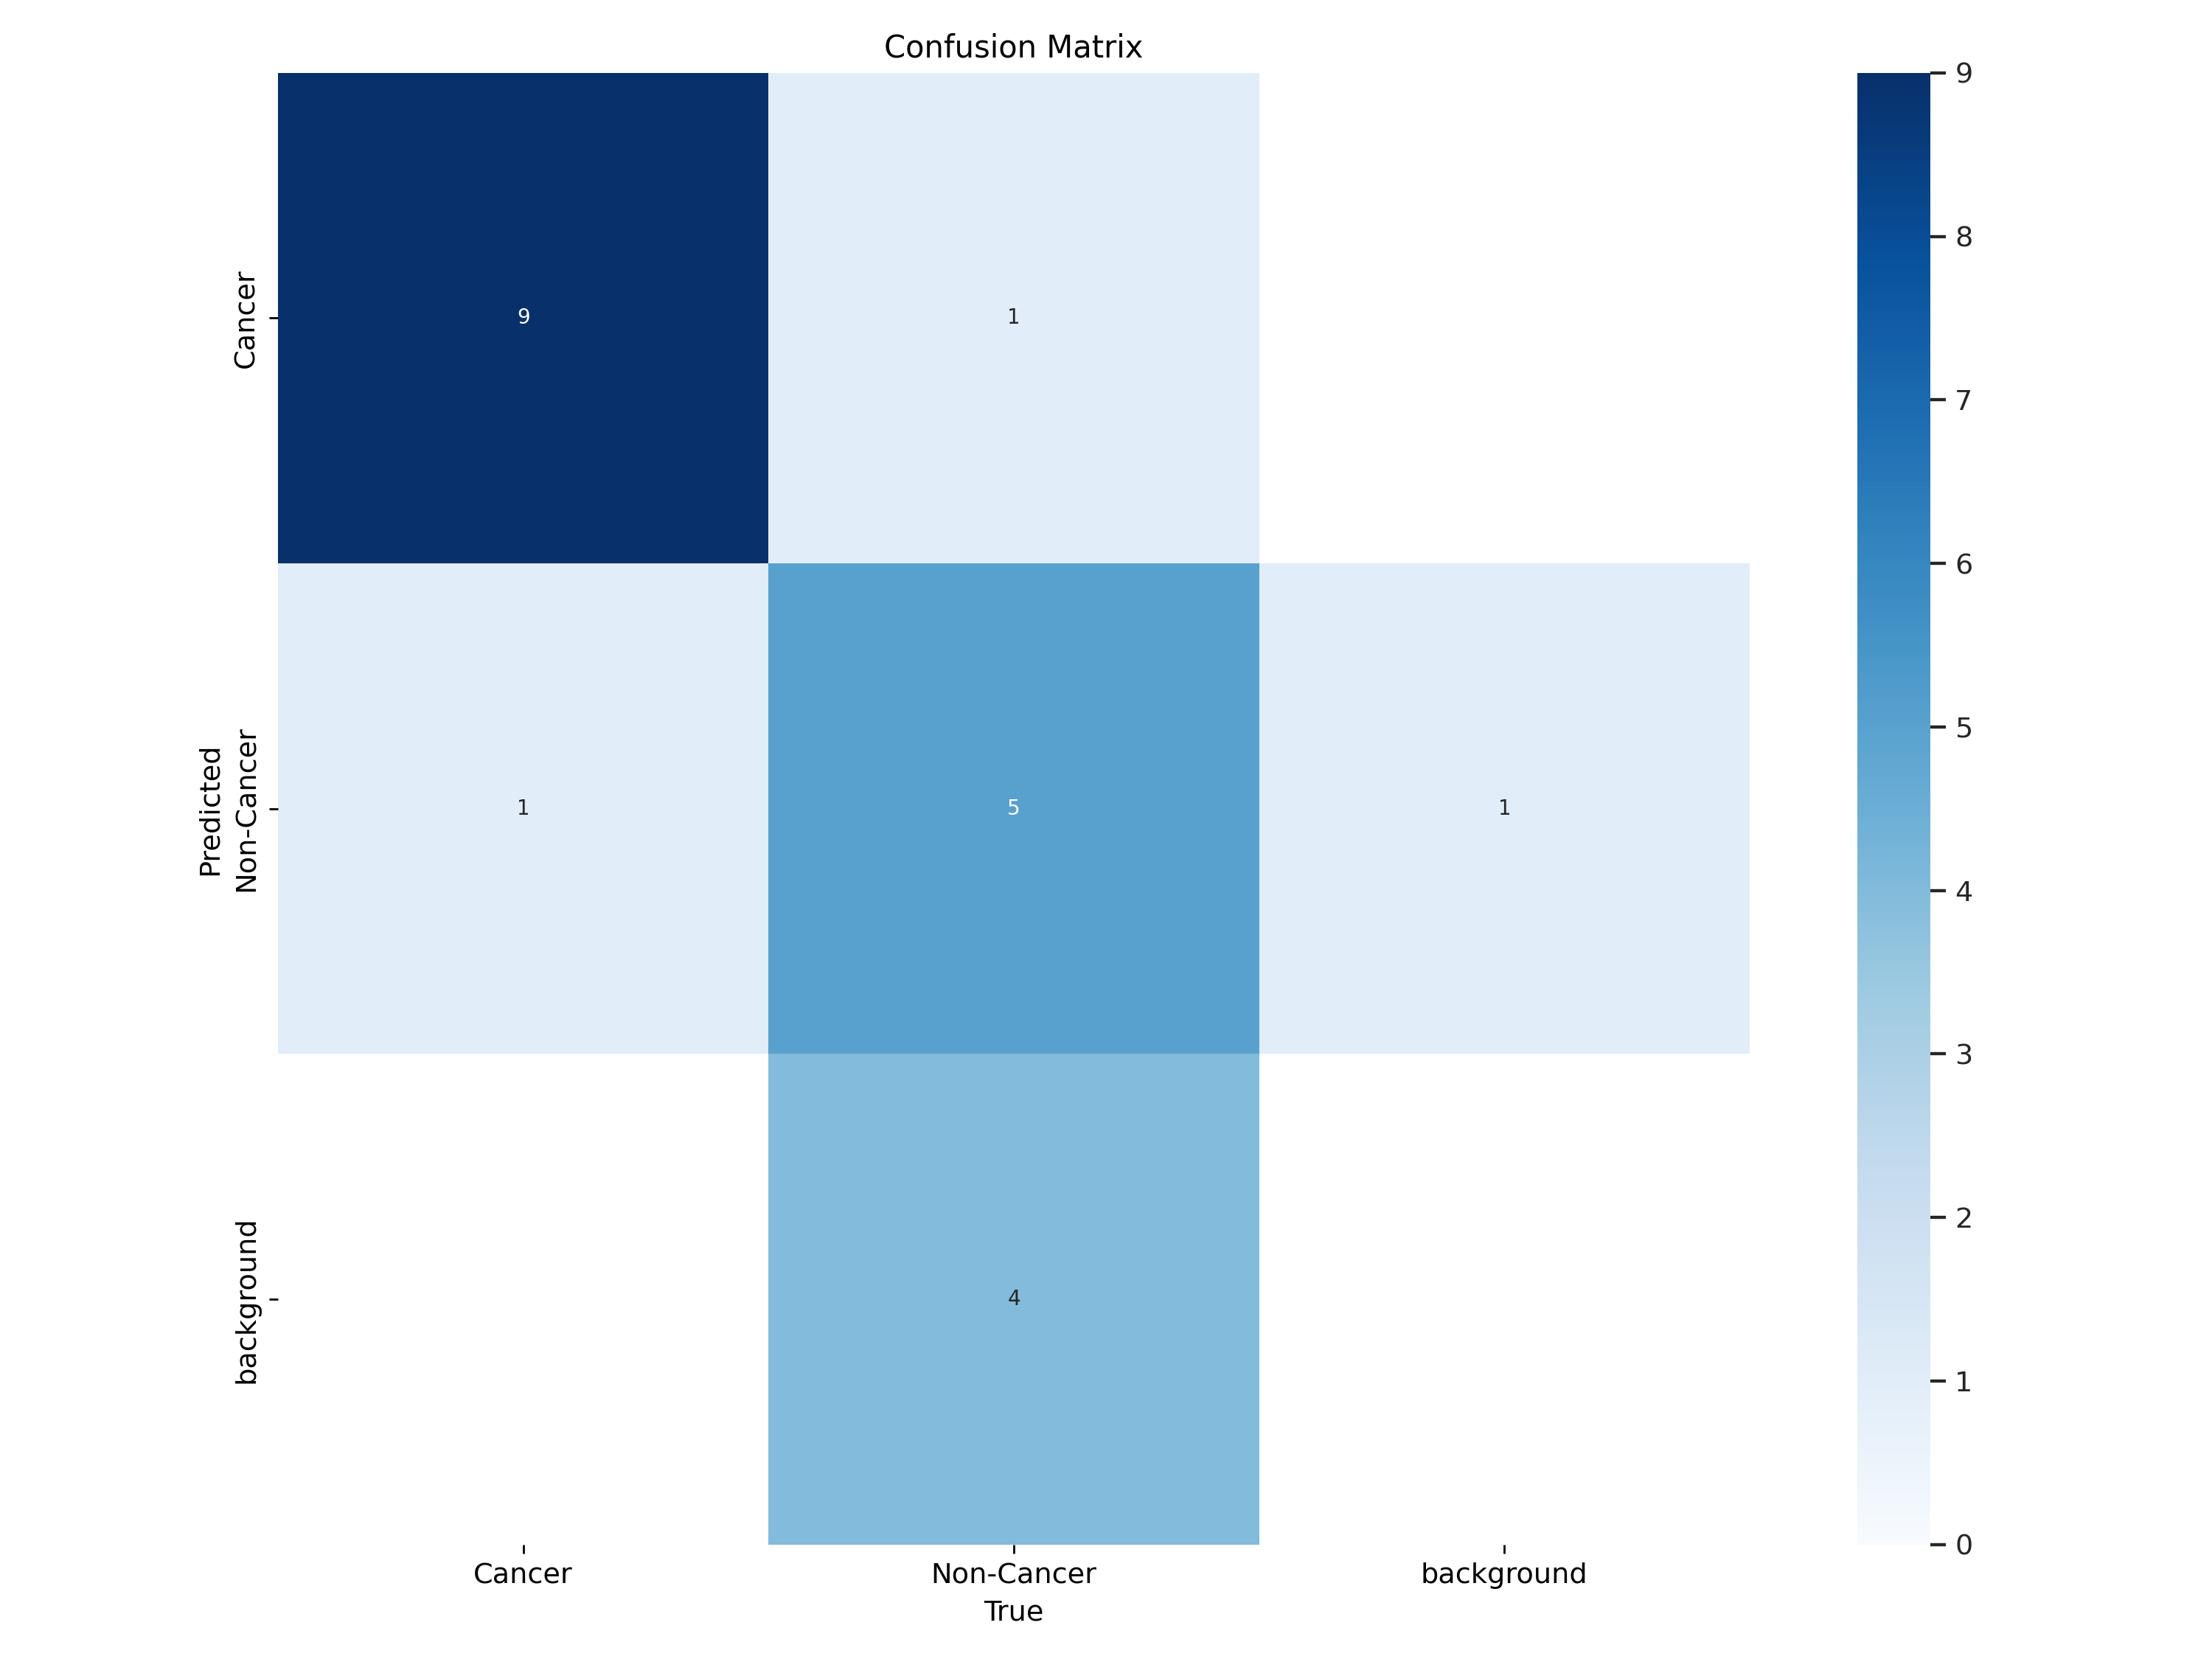

In [13]:
# Confusion Matrix from training
display(Image(filename=f'{results_path}/confusion_matrix.png', width=600))

In [14]:
# prompt: deploy my model up to roboflow

# Assuming your trained model is in the 'runs/detect/train' directory
# Replace 'your_model_name.pt' with the actual name of your trained model file
!roboflow deploy -m runs/detect/train/weights/best.pt -n skin-cancer-detection-model --api-key "GybthxK3Mzs6LO2oHyMZ"


usage: roboflow [-h] [-v]
                {login,download,upload,import,infer,project,workspace,upload_model,get_workspace_info,run_video_inference_api,deployment,whoami}
                ...
roboflow: error: argument {login,download,upload,import,infer,project,workspace,upload_model,get_workspace_info,run_video_inference_api,deployment,whoami}: invalid choice: 'deploy' (choose from 'login', 'download', 'upload', 'import', 'infer', 'project', 'workspace', 'upload_model', 'get_workspace_info', 'run_video_inference_api', 'deployment', 'whoami')


## Loss Fucntion Interpretation


- `box_loss`: This is the bounding box regression loss, which measures the error in the predicted bounding box coordinates and dimensions compared to the ground truth. A lower box_loss means that the predicted bounding boxes are more accurate.

- `cls_loss`: This is the classification loss, which measures the error in the predicted class probabilities for each object in the image compared to the ground truth. A lower cls_loss means that the model is more accurately predicting the class of the objects.


### Intuition

- **High Box Loss**: This indicates that the model is struggling to accurately predict the location of the objects (bounding boxes). The predicted boxes may not align well with the actual objects, either being too large, too small, or misplaced. You can improve this by using higher-quality labeled data, adjusting anchor box sizes, or further tuning the model to refine its ability to predict precise bounding boxes.

- **High Classification (Cls) Loss**: This means that the model is misclassifying objects or uncertain about which class the detected objects belong to. The model might be confused between similar classes, leading to incorrect predictions. Improving this often involves refining the quality of the training labels, ensuring there is sufficient differentiation between classes, or using more diverse data to help the model distinguish between categories better.


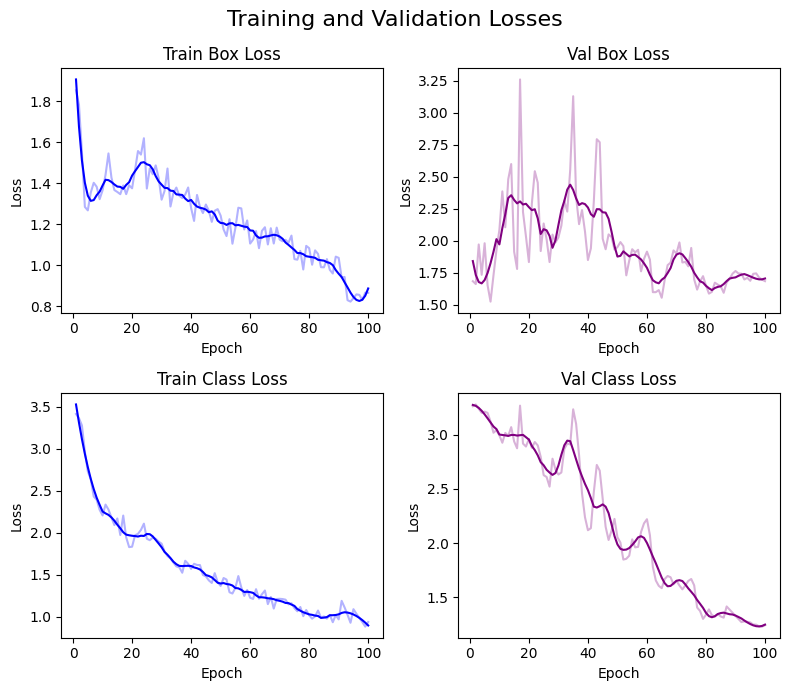

In [15]:
# Read the results CSV file
results_df = pd.read_csv(f'{results_path}/results.csv')

# Strip leading spaces from column names
results_df.columns = results_df.columns.str.strip()

# Create a 2x2 subplot for losses
fig, axs = plt.subplots(2, 2, figsize=(8, 7))
fig.suptitle('Training and Validation Losses', fontsize=16)

# Function to plot smooth line
def plot_smooth_line(ax, x, y, label, color):
    ax.plot(x, y, alpha=0.3, color=color, label=f'{label} (Raw)')
    window_length = min(15, len(y) - 1 if len(y) % 2 == 0 else len(y) - 2)
    if window_length > 2:
        y_smooth = savgol_filter(y, window_length, 3)
        ax.plot(x, y_smooth, color=color, label=f'{label} (Smooth)')

# Train Box Loss
plot_smooth_line(axs[0, 0], results_df['epoch'], results_df['train/box_loss'], 'Train Box Loss', 'blue')
axs[0, 0].set_title('Train Box Loss')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Loss')

# Val Box Loss
plot_smooth_line(axs[0, 1], results_df['epoch'], results_df['val/box_loss'], 'Val Box Loss', 'purple')
axs[0, 1].set_title('Val Box Loss')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Loss')

# Train Class Loss
plot_smooth_line(axs[1, 0], results_df['epoch'], results_df['train/cls_loss'], 'Train Class Loss', 'blue')
axs[1, 0].set_title('Train Class Loss')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Loss')

# Val Class Loss
plot_smooth_line(axs[1, 1], results_df['epoch'], results_df['val/cls_loss'], 'Val Class Loss', 'purple')
axs[1, 1].set_title('Val Class Loss')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Loss')

plt.tight_layout()
plt.show()

## Precision and Recall Graph

- **Precision** is how many of the objects the car correctly identifies as obstacles out of all the ones it marked as obstacles
- **Recall** is how many actual obstacles the car correctly detected out of all the obstacles present in its path.

### Intuition

- **Low Precision:** The model may be detecting too many non-existent objects. Adjusting confidence thresholds might reduce this.
- **Low Recall:** The model could be missing real objects. Improving feature extraction or using more data might help.

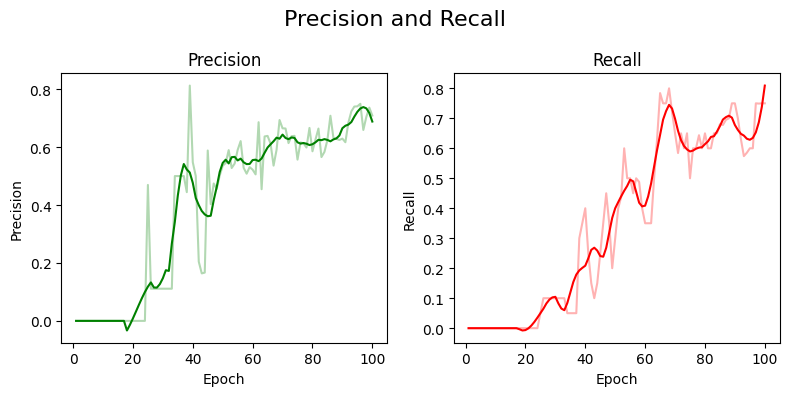

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle('Precision and Recall', fontsize=16)

# Precision
plot_smooth_line(axs[0], results_df['epoch'], results_df['metrics/precision(B)'], 'Precision', 'green')
axs[0].set_title('Precision')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Precision')

# Recall
plot_smooth_line(axs[1], results_df['epoch'], results_df['metrics/recall(B)'], 'Recall', 'red')
axs[1].set_title('Recall')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Recall')


plt.tight_layout()
plt.show()